In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.units import *
from utils.rbconsts import *
from dataclasses import dataclass
from typing import Optional

Some questions to answer:
- how many pixels per camera for each atom? depends on imaging magnification choice,
will affect the readout noise (same QE, but higher overall noise if more pixels used)
- is it possible to use a small enough number of rows on the Orca that it comes out on top?
- at what point does readout speed become the limiting factor? (photon collection rate determines the exposure we need)

In [2]:
# lots of caveats for speed comparison. could include some kind of dictionary to capture rate dependence on 
# factors such as number of rows to read out (for CMOS) or bit depth (for SPAD),
# but for now I'll just make dedicated instances for different camera configurations

@dataclass
class Camera:
    name: str
    QE: float # at 780 nm
    frame_rate: int
    pixel_width_um: int
    pixel_height_um: int
    num_pixel_rows: int
    num_pixel_cols: int
    bit_depth: int # not relevant for Orca cameras with CoaXPress connection
    readout_noise: float # e/pix/s
    dark_noise: float # e/pix/s
    min_exp_s: float
    max_exp_s: float
    data_rate: Optional[float] = None

    def __post_init__(self):
        if 'SPAD' in self.name:
            self.type = 'SPAD'
        elif 'CMOS' in self.name:
            self.type = 'SPAD'
        else:
            self.type = 'other'

        if self.data_rate != None:
            self.transfer_time = self.num_pixel_rows*self.num_pixel_cols*float(self.bit_depth)/self.data_rate
        else:
            self.transfer_time = -1 # obviously not
        
    # currently unused
    def signal_correction(self, count_rate: float):
        """
        camera tech-specific signal correction for measured data
        """
        if self.type == 'SPAD':
            det_rate = count_rate/(1 + count_rate*dead_time)
            return det_rate
        if self.type == 'CMOS':
            return count_rate
        else:
            return count_rate

    def noise(self, count_rate:float, t:float) -> float:
        """
        mean number of noise counts in exposure time t (s) given
        camera noise and shot noise from counts/s
        """

        return np.sqrt(self.dark_noise*t 
                       + self.readout_noise**2 # per readout, not per second
                       + self.signal(count_rate, t) # for Poisson dist (shot noise)
                      )

    def signal(self, count_rate: float, t:float) -> float:
        """
        for actual counts/s incident on a pixel and exposure time t (s), 
        return the mean number of counts detected by a pixel on the camera
        """
        return self.QE*count_rate*t

    def snr(self, count_rate: float, t:float) -> float:
        """
        Return signal to noise ratio for given counts/s and exposure time t (s)
        """
        return self.signal(count_rate, t)/self.noise(count_rate, t)

## Pi imaging white paper comparison
try to reproduce the conclusions from the whitepaper

In [3]:
# SPAD512 specs:
# https://piimaging.com/datasheet/SPAD512Sdatasheet.pdf

SPAD512_highspeed = Camera(
    name='SPAD512 - High Speed',
    QE=0.5,
    frame_rate=400,
    pixel_width_um=16,
    pixel_height_um=16,
    num_pixel_rows=512,
    num_pixel_cols=512,
    bit_depth=10,
    readout_noise=0,
    dark_noise=24,
    min_exp_s=6e-9, # the gate width
    max_exp_s=1, # can't readout continuously at max speed
    data_rate=6e9 # per s
)

# from Pi Imaging white sheet comparison. -1 means spec wasn't given
sCMOS_test = Camera(
    name='sCMOS Pi Imaging comparison',
    QE=0.73, # by eye from spec sheet               
    frame_rate=-1,
    pixel_width_um=9,
    pixel_height_um=9,
    num_pixel_rows=612, # cropped region
    num_pixel_cols=612,
    bit_depth=10,
    readout_noise=1.38,
    dark_noise=7.4,
    min_exp_s=14e-6,
    max_exp_s=-1
)

In [4]:
cameras = [
    SPAD512_highspeed,
    sCMOS_test
]

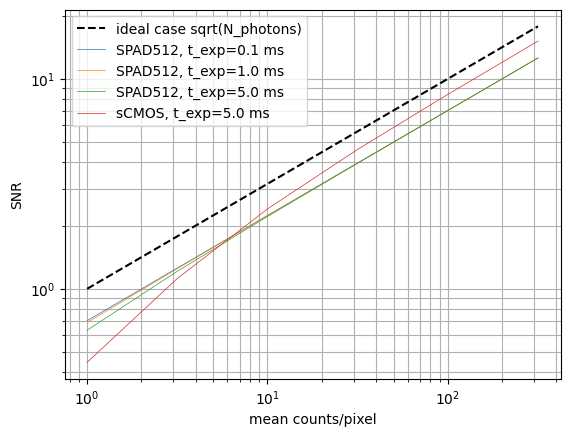

In [5]:
# plot per-pixel SNR vs incident count rate per pixel
# I can't seem to get good agreement with the data in the 
# whitepaper, but my expressions are verified by several sources.
# probably there is some experimental reason for the deviation from
# theory, or the expressions I am using need some correction 
# functions.

# the SPAD whitepaper adjusted exposure time for the two cameras
# to have same effective number of photons impinging on each of them.
# i just assume I've illuminated only one pixel on each camera to 
# satisfy this condition by choice of the spatial mode size at the 
# pixel.

t_exp = [0.1*ms, 1*ms, 5*ms]
counts = np.array([10**i for i in np.arange(0,3,0.5)]) # counts impinging on a pixel within the exposure time
ideal_snr = np.sqrt(counts) # shot noise limited

fig,ax = plt.subplots(dpi=100)

ax.plot(counts, ideal_snr, label='ideal case sqrt(N_photons)', ls='--',c='k')
# SPAD camera
for t in t_exp:
    ax.plot(counts, cameras[0].snr(counts/t, t), label=f'SPAD512, t_exp={t/ms:.1f} ms', lw=0.5)
t = 5e-3
ax.plot(counts, cameras[1].snr(counts/t, t), label=f'sCMOS, t_exp={t/ms:.1f} ms', lw=0.5)
ax.legend()
ax.set_xlabel("mean counts/pixel")
ax.set_ylabel("SNR")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which='both', axis='both')
plt.show()

## SPADs vs Orca Quest 2
comparison at 780 nm

In [6]:
# SPAD512 specs:
# https://piimaging.com/datasheet/SPAD512Sdatasheet.pdf

SPAD512_highspeed = Camera(
    name='SPAD512 - High Speed',
    QE=0.15, # by eye from spec sheet               
    frame_rate=1e5,
    pixel_width_um=16,
    pixel_height_um=16,
    num_pixel_rows=512,
    num_pixel_cols=512,
    bit_depth=1,
    readout_noise=0,
    dark_noise=24,
    min_exp_s=6e-9, # the gate width
    max_exp_s=1, # can't readout continuously at max speed
    data_rate=6e9
)

# Orca Quest 2 specs:
# https://www.hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/sys/SCAS0166E_C15550-22UP.pdf

# full frame
OrcaQuest2_UltraQuiet = Camera(QE=0.47, # by eye from spec sheet
    name='OQ2 - UltraQuiet Scan, full frame',
    frame_rate=25, # with CoaXPress
    pixel_width_um=16,
    pixel_height_um=16,
    num_pixel_rows=2304,
    num_pixel_cols=4096,
    bit_depth=1,
    readout_noise=0.3,
    dark_noise=0.006, # e/pix/s at -35 C
    min_exp_s=33.9e-6,
    max_exp_s=1800 
)

# full frame
OrcaQuest2_Standard = Camera(
    name='OQ2 - Standard Scan, full frame',
    QE=0.47, # by eye from spec sheet
    frame_rate=120, # with CoaXPress
    pixel_width_um=16,
    pixel_height_um=16,
    num_pixel_rows=2304,
    num_pixel_cols=4096,
    bit_depth=1,
    readout_noise=0.48,
    dark_noise=0.006, # e/pix/s at -35 C
    min_exp_s=7.2e-6,
    max_exp_s=1800 
)

# subarray with same number of rows as SPAD512, ultraquiet
OrcaQuest2_UltraQuiet_512rows = Camera(
    name='OQ2 - UltraQuiet Scan, 512 rows',
    QE=0.47, # by eye from spec sheet
    frame_rate=112, # with CoaXPress
    pixel_width_um=4.6,
    pixel_height_um=4.6,
    num_pixel_rows=512,
    num_pixel_cols=4096,
    bit_depth=-1,
    readout_noise=0.3,
    dark_noise=0.006, # e/pix/s at -35 C
    min_exp_s=33.9e-6,
    max_exp_s=1800,
    data_rate=6e9
)

# subarray with same number of rows as SPAD512, ultraquiet
OrcaQuest2_Standard_512rows = Camera(
     name='OQ2 - Standard Scan, 512 rows',
     QE=0.47, # by eye from spec sheet
     frame_rate=532, # with CoaXPress
     pixel_width_um=4.6,
     pixel_height_um=4.6,
     num_pixel_rows=512,
     num_pixel_cols=4096,
     bit_depth=-1,
     readout_noise=0.48,
     dark_noise=0.006, # e/pix/s at -35 C
     min_exp_s=7.2e-6,
     max_exp_s=1800
    
)

In [7]:
cameras = [
    SPAD512_highspeed,
    OrcaQuest2_Standard, 
    OrcaQuest2_UltraQuiet, 
    # OrcaQuest2_UltraQuiet_512_rows, 
    # OrcaQuest2_Standard_512rows
]

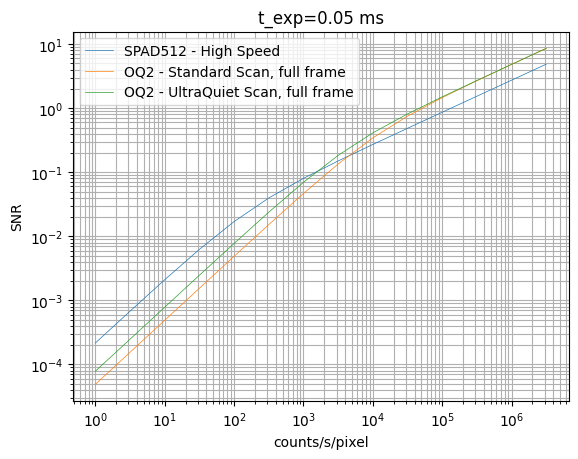

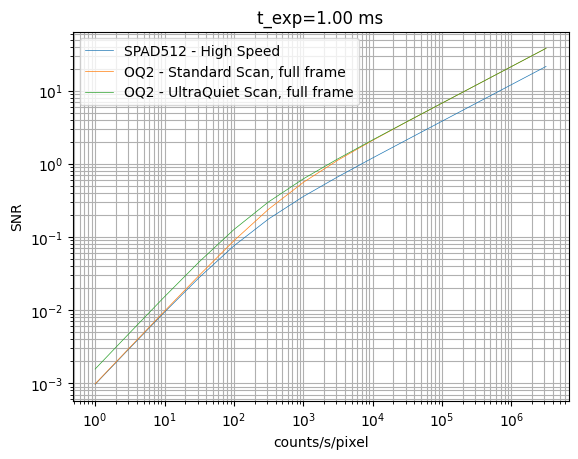

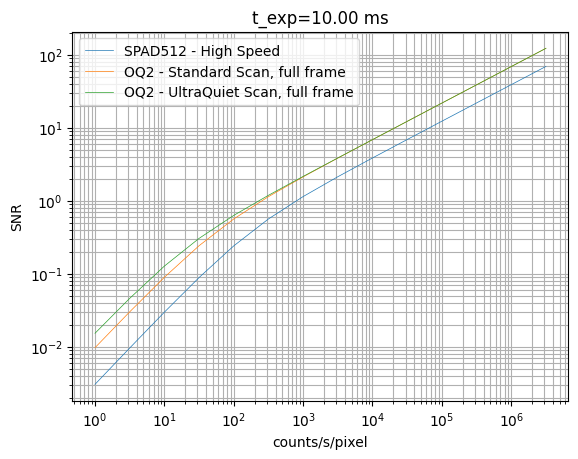

In [9]:
# plot SNR vs incident count rate per pixel at fixed exposure

t_exp = [0.05*ms, 1*ms, 10*ms]
count_rate = np.array([10**i for i in np.arange(0,7,0.5)])

for t in t_exp:
    fig,ax = plt.subplots(dpi=100)
    for cam in cameras:
        assert t > cam.min_exp_s, (f"t_exp={t/us:.2f} us is below the minimum" 
                                   +f"{cam.min_exp_s/us:.2f} us for {cam.name}")
        ax.plot(count_rate, cam.snr(count_rate, t), label=cam.name, lw=0.5)
    ax.legend()
    ax.legend()
    ax.set_title(f't_exp={t/ms:.2f} ms')
    ax.set_xlabel("counts/s/pixel")
    ax.set_ylabel("SNR")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(which='both')
    plt.show()

In [186]:
# what about how long it takes to get to a certain imaging fidelity?

In [187]:
cameras[0].transfer_time

4.3690666666666665e-05